# Start image visualization

Select a procedure/ablation/policy/task and visualize the subset in the best permutation (by a metric), highlighting the start image.

In [1]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

REPO_ROOT = Path("/data/ddmg/mvseg-ordering")
for path in [REPO_ROOT, REPO_ROOT / "UniverSeg", REPO_ROOT / "MultiverSeg", REPO_ROOT / "ScribblePrompt",]:
    if str(path) not in sys.path:
        sys.path.append(str(path))

from experiments.analysis.planb_utils import load_planb_summaries
from experiments.dataset.mega_medical_dataset import MegaMedicalDataset



# ---- Config ----
procedure = 'fixed_uncertainty'
ablation = 'curriculum'
policy_name = 'curriculum'
dataset = 'ACDC'
task_id = 'ACDC/ACDC_Challenge2017_MRI_2_label1_midslice_idx1'
subset_index = 0
score_metric = 'initial_dice'
higher_is_better = True


In [2]:
def parse_task_dir(task_dir: str):
    """Return (task, label, slicing) from task dir name."""
    m = re.match(r'^(?P<base>.+)_label(?P<label>\d+)_(?P<slicing>midslice|maxslice)_idx(?P<idx>\d+)$', task_dir)
    if not m:
        raise ValueError(f'Unexpected task dir format: {task_dir}')
    base = m.group('base')
    label = int(m.group('label'))
    slicing = m.group('slicing')
    task = base.replace('_', '/')
    return task, label, slicing

def extract_image(sample):
    """Extract image tensor/array from dataset sample."""
    if isinstance(sample, dict):
        if 'img' in sample:
            return sample['img']
        if 'image' in sample:
            return sample['image']
        # Fallback: first value
        return next(iter(sample.values()))
    if isinstance(sample, (tuple, list)):
        return sample[0]
    return sample

def to_numpy_img(img):
    if hasattr(img, 'detach'):
        img = img.detach().cpu()
    if hasattr(img, 'numpy'):
        img = img.numpy()
    arr = np.asarray(img)
    # Drop singleton dims (e.g., 1xHxW or 1x1xHxW)
    arr = np.squeeze(arr)
    # Convert channel-first (C,H,W) -> (H,W,C)
    if arr.ndim == 3 and arr.shape[0] in (1, 3) and arr.shape[0] < arr.shape[-1]:
        arr = np.transpose(arr, (1, 2, 0))
    # If single-channel last dim, drop it
    if arr.ndim == 3 and arr.shape[-1] == 1:
        arr = arr[..., 0]
    return arr


In [3]:
# ---- Load Plan B summaries ----
df = load_planb_summaries(
    repo_root=REPO_ROOT,
    procedure=procedure,
    ablation=ablation,
    dataset=dataset,
)
df = df[df['policy_name'] == policy_name]
df = df[df['task_id'] == task_id]
df = df[df['subset_index'] == subset_index]

if df.empty:
    raise ValueError('No rows found for the selected filters.')

# Per-permutation mean score in subset
perm_scores = (
    df.groupby(['subset_index', 'permutation_index'])[score_metric]
      .mean()
      .reset_index()
)

if higher_is_better:
    best_perm = perm_scores.loc[perm_scores[score_metric].idxmax(), 'permutation_index']
else:
    best_perm = perm_scores.loc[perm_scores[score_metric].idxmin(), 'permutation_index']

best_df = df[df['permutation_index'] == best_perm].copy()
best_df = best_df.sort_values('image_index')

start_row = best_df[best_df['image_index'] == 0]
if start_row.empty:
    raise ValueError('No start image (image_index==0) found for best permutation.')
start_image_id = int(start_row.iloc[0]['image_id'])

# Unique subset image IDs (use this for subset size)
subset_image_ids = sorted(int(x) for x in df['image_id'].unique())
# Best-permutation order (optional visualization order)
best_perm_image_ids = [int(x) for x in best_df['image_id'].tolist()]

use_best_perm_order = True
if use_best_perm_order and len(best_perm_image_ids) != len(subset_image_ids):
    print('Warning: best permutation image count differs from subset size; using unique subset IDs instead.')
    use_best_perm_order = False

image_ids = best_perm_image_ids if use_best_perm_order else subset_image_ids
order_label = 'best permutation order' if use_best_perm_order else 'subset unique order'

print(f'Best permutation: {best_perm}')
print(f'Start image id: {start_image_id}')
print(f'Total images in subset: {len(subset_image_ids)}')
print(f'Images shown: {len(image_ids)} ({order_label})')


Best permutation: 5
Start image id: 23
Total images in subset: 10
Images shown: 10 (best permutation order)


In [4]:
# ---- Load dataset items ----
task_dir = task_id.split('/', 1)[1]
task, label, slicing = parse_task_dir(task_dir)

ds = MegaMedicalDataset(
    task=task,
    label=label,
    slicing=slicing,
    split='train',
    dataset_size=None,
)

images = []
for img_id in image_ids:
    sample = ds.get_item_by_data_index(img_id)
    img = to_numpy_img(extract_image(sample))
    images.append(img)


No updates to index
Filtered task_df: 1248
got task df: 1248


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


target_datasets: 1248


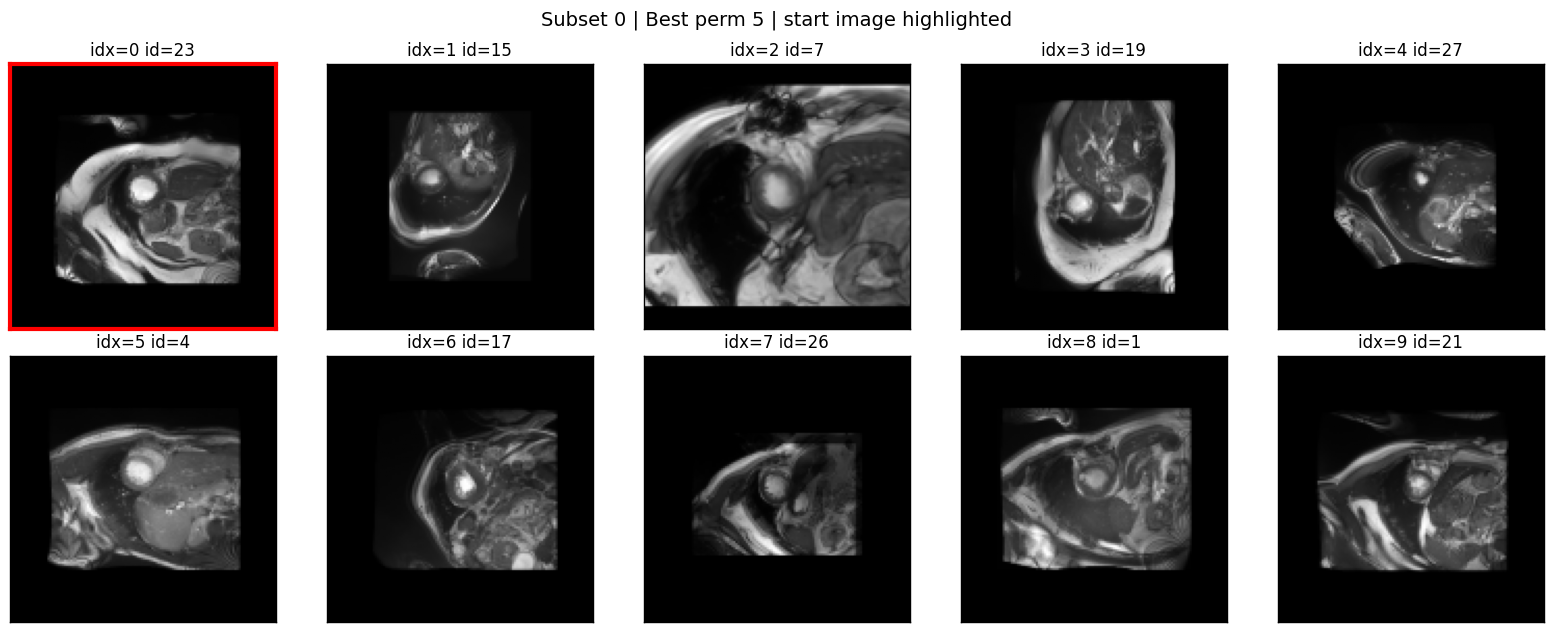

In [5]:
# ---- Visualize subset (best permutation order) ----
n = len(images)
ncols = min(5, n)
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(3.2 * ncols, 3.2 * nrows))
axes = np.array(axes).reshape(-1)

for i, (img, img_id) in enumerate(zip(images, image_ids)):
    ax = axes[i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f'idx={i} id={img_id}')
    ax.set_xticks([])
    ax.set_yticks([])
    # Highlight start image
    is_start = (img_id == start_image_id) or (i == 0 and use_best_perm_order)
    if is_start:
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)
    else:
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1)

# Hide extra axes
for j in range(n, len(axes)):
    axes[j].axis('off')

fig.suptitle(
    f'Subset {subset_index} | Best perm {best_perm} | start image highlighted',
    fontsize=14,
)
plt.tight_layout()
plt.show()
